Inspired by [paper](https://www.researchgate.net/publication/237135894_A_unifying_framework_for_complexity_measures_of_finite_systems)

In this notebook I will implement TSE and Excess Entropy calculation and test it on following datasets:



1.   Wikipedia
2.   Simple English Wikipedia


# Preparation

In [1]:
!python3 -m pip install sentencepiece > /dev/null && echo 'OK'

OK


In [2]:
!python3 -m pip install tensorflow_text > /dev/null && echo 'OK'

OK


In [3]:
!python3 -m pip install tensorflow_datasets > /dev/null && echo 'OK'

OK


In [4]:
!python3 -m pip install tf_sentencepiece > /dev/null && echo 'OK'

OK


### Imports

In [5]:
import sentencepiece as spm
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Tuple
import nltk
import matplotlib.pyplot as plt

# Datasets

## Wikipedia

[link](https://www.tensorflow.org/datasets/catalog/wiki40b#wiki40ben_default_config) to dataset

In [6]:
ds = tfds.load('wiki40b/en', split='train', shuffle_files=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset wiki40b downloaded and prepared to /root/tensorflow_datasets/wiki40b/en/1.3.0. Subsequent calls will reuse this data.


In [7]:
MAX_TEXTS_SIZE = 1000

texts = []
for x in ds:
    if len(texts) > MAX_TEXTS_SIZE:
        break
    s = x['text'].numpy().decode('utf-8')
    text = s.replace('_NEWLINE_', ' ').replace('_START_ARTICLE_', '').replace('_START_PARAGRAPH_', '').replace('_START_SECTION_',' ').split('\n')
    texts += list(filter(lambda x: len(x) > 20, text))

In [8]:
with open('train_text.txt', 'w') as fout:
    for text in texts:
        fout.write(text)
        fout.write('\n')

In [9]:
spm.SentencePieceTrainer.train('--input=train_text.txt --model_prefix=m --vocab_size=500')

In [64]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', 'a', '.', 'o', 'n', '▁a', 'ed', 'd', 'c', '▁in', '▁of', 'i', 'y', 'er', 'p', '▁and', 'ing', 'u', 'm', '▁to', 'al', 'ar', 'h', '▁s', 'b', 'or', 'g', 'f', 'w', 'r', 're', 'in', 'en', 'le', 'an', 'on', 'ur', '▁c', 'l', 'k', '▁was', 'ri', '▁S', '▁f', 'ch', 'st', '▁re', 'th', '▁A', '▁C', 'v', '-', 'ra', 'it', '▁The', 'ro', 'es', '▁B', '▁for', '▁p', 'ic', 'il', 'ly', 'ent', "'", 'ter', '▁(', '▁P', '1', '▁on', 'am', '▁be', '▁b', 'at', '▁with', 'ad', '▁T', 'ation', '▁D', ')', '▁is', '▁19', '▁as', 'us', '▁M', 'el', 'ne', '▁In', '▁H', '▁F', '5', 'lo', 'li', '0', '9', '▁de', '▁W', '▁his', 'ce', '▁by', 'un', '▁he', '8', '▁m', '2', 'om', '4', '7', 'la', '▁2', 'as', '▁G', '6', 'nd', '▁N', 'is', 'ol', '▁d', '"', 'se', '▁g', 'vi', '▁1', '▁at', '▁that', 'ver', 'ng', '▁st', 'et', 'ir', '3', '▁con', 'all', 'ion', 'im', 've', 'x', 'ut', '▁"', 'te', '▁from', 'ate', 'ul', 'z', '▁t', '▁e', '▁mo', 'ive', 'id', '▁K', 'ment', 'ck', '▁an', '▁l', '▁ha', '▁

In [10]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [13]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[96, 244, 11, 7, 111, 20, 51, 49, 40, 15]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'en', 'd']


In [62]:
def collect_statistics(
    texts: List[str], 
    sp: spm.SentencePieceProcessor
) -> Tuple[np.ndarray]:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer

    Returns
    - a nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    - a nltk.FreqDist with counts for (i, x_i)
    """

    vocab_size = sp.vocab_size()
    bins = np.arange(vocab_size + 1)

    F_pair = nltk.FreqDist()
    F_single = nltk.FreqDist()

    for text in tqdm(texts):
        tokenized_sequence = sp.encode_as_ids(text)
        bgs = nltk.bigrams(tokenized_sequence)
        F_pair += nltk.FreqDist(zip(range(1, len(tokenized_sequence)), bgs))
        F_single += nltk.FreqDist(zip(range(len(tokenized_sequence)), tokenized_sequence))
    
    return F_pair, F_single

In [63]:
F_pair, F_single = collect_statistics(texts, sp)

In [228]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))

['<unk>', '<s>', '</s>', '▁', 's', '▁the', 'e', ',', 'a', '.', 't', 'o', 'n', '▁of', 'ed', 'y', 'd', '▁a', '▁in', 'u', '▁and', 'i', 'c', 'p', 'ing', 'er', 'b', '▁to', 'r', 'g', 'al', 'm', 'or', 'ar', 'in', 're', 'l', 'le', 'k', 'an', 'f', 'st', '▁S', 'ri', '▁A', 'en', '▁was', '▁f', 'h', 'w', 'on', 'th', 'ic', '▁re', '▁c', '1', '▁The', 'it', 'ch', '-', '▁B', 'ur', 'es', '▁for', '▁P', 'v', 'ly', 'ent', '▁w', '0', 'ation', '▁p', 'ter', '▁C', '▁M', '▁on', "'", 'ra', '▁is', '▁with', '▁(', 'ro', '▁19', 'at', 'us', 'il', '▁de', 'te', 'ad', '▁as', '▁F', '▁T', 'un', '5', 'ng', '▁G', '▁H', '9', 'ce', '▁by', '4', '▁be', 'is', '2', '▁20', '6', '▁In', 'el', '7', '▁he', '▁W', 'vi', '▁m', '▁D', 'la', '8', 'ir', 'se', '▁that', 'ver', 'ow', '▁e', '▁at', '▁E', '▁his', '▁con', 'L', '3', '"', 'as', '▁1', '▁from', '▁pro', 'li', 've', 'ck', 'ment', 'ul', '▁N', 'lo', '▁ma', '▁mo', 'am', 'ate', 'z', 'ol', ')', '▁se', 'x', 'et', '▁g', 'me', 'ne', 'id', 'j', '▁an', 'im', '▁"', 'ut', 'ill', 'ist', '▁R', 'ke', '▁

## Simple English wikipedia

some [link](https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

# Calculating metrics

## Excess Entropy

Friendly reminder:

Suppose that we have a sequence of tokens $x_0, x_1, \ldots, x_{n-1}$.
We want to calculate $E(x_0, x_1, \ldots, x_{n-1})$

In original papers this metrics can be calculated only of some multidimensional random value, but not of sequence of numbers. 

So, $E(X_0, X_1, \ldots, X_{n-1}) = (n-1)\left(\frac{1}{n-1}\sum\limits_{i=0}^{n-1}H(X_0, X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_{n-1}) - H(X_0, \ldots, X_{n-1})\right)$

The problem is how to calculate $H(\ldots)$ if we have only a sequence of numbers.

First of all, let's simplify the problem: we want to create such r.v. $\xi_i$ from our numbers in such a way that $H(\xi_0, \ldots, \xi_{n-1}) = H(\xi_0) + H(\xi_1|\xi_0) + \ldots + H(\xi_{n-1}|\xi_{n-2})$. How can we find such r.v.?

Notice that $xi_i$ should depends on the position ($i$) in the sequence and on number at this position ($x_i$).

Let's construct r.v. by $x_i$. So, $x_i$ will generate r.v. $\xi^i_{x_i}$. What the distribution of such r.v. is?

* $p(\xi^0_{x_0}) = \frac{\#\text{sequences with $x_0$ at the very beginning}}{\#\text{of first positions}}$

* $p(\xi^i_{x_i} | \xi^{i-1}_{x_{i-1}}) = \frac{\#\text{sequences with $x_{i-1}$ at position $i-1$ and $x_i$ at position $x_i$}}{\#\text{sequences with $i$-th position}}$

Then we can define Excess Entropy of sequence of numbers

$E(x_0, \ldots, x_{n-1}) = E(\xi^0_{x_0}, \xi^1_{x_1}, \ldots, \xi^{n-1}_{x_{n-1}})$

How to calculate it efficiently?

Let's denote $\mu_i = \xi^i_{x_i}$

* $\hat{H} = H(\mu_0, \ldots, \mu_{n-1}) = H(\mu_0) + H(\mu_1|\mu_0) + \ldots + H(\mu_{n-1} | \mu_{n-2})$
    * $H(\mu_i) = -p(\mu_i)\log p(\mu_i)$
    * $H(\mu_i|\mu_{i-1}) = -p(\mu_i|\mu_{i-1})\log p(\mu_i|\mu_{i-1})$
* $H(\mu_0, \ldots, \mu_{i-1}, \mu_{i+1}, \ldots, \mu_{n-1}) = \hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1}|\mu_{i-1}) = $
$=\hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1})$

**Note**: if we will define r.v. which depends only on values then we can not easily calculate Excess entropy, because there is dependency between all r.v.

In [103]:
def calculate_excess_entropy(
    texts: List[str], 
    sp: spm.SentencePieceProcessor,
    F_pair: nltk.FreqDist,
    F_single: nltk.FreqDist
) -> np.ndarray:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer
    F_pair: nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    F_single: nltk.FreqDist with counts for (i, x_i)

    Returns
    - a (# of texts,) numpy array with excess entropy calculated for each text
    """

    EPS = 1e-9
    def calculate_entropy(p):
        return -p * np.log(p + EPS) - (1 - p) * np.log(1 - p)

    def H_pair(i, prev, cur):
        return calculate_entropy(F_pair.freq((i, (prev, cur))))

    def H_single(i, xi):
        return calculate_entropy(F_single.freq((i, xi)))

    ee = np.zeros(len(texts), dtype=float)

    for id, text in tqdm(enumerate(texts)):
        x = sp.encode_as_ids(text)
        n = len(x)
        H_hat = 0
        delta = 0
        for i in range(n):
            if i == 0:
                H_hat += H_single(0, x[i])
            else:
                H_hat += H_pair(i, x[i - 1], x[i])

            if i > 0:
                delta += -H_pair(i, x[i - 1], x[i])
            if i + 1 < n:
                delta += -H_pair(i + 1, x[i], x[i + 1]) + H_single(i + 1, x[i + 1])
        ee[id] = delta + H_hat

    return ee

In [99]:
F_pair.items()

dict_items([((1, (207, 40)), 3), ((2, (40, 303)), 3), ((3, (303, 48)), 1), ((4, (48, 80)), 7), ((5, (80, 33)), 8), ((6, (33, 12)), 9), ((7, (12, 17)), 5), ((8, (17, 89)), 4), ((9, (89, 110)), 3), ((10, (110, 112)), 2), ((11, (112, 17)), 1), ((12, (17, 286)), 1), ((13, (286, 39)), 1), ((14, (39, 57)), 1), ((15, (57, 11)), 3), ((16, (11, 108)), 1), ((17, (108, 8)), 2), ((18, (8, 20)), 1), ((19, (20, 7)), 2), ((20, (7, 57)), 3), ((21, (57, 28)), 3), ((22, (28, 189)), 2), ((23, (189, 33)), 2), ((24, (33, 12)), 2), ((25, (12, 203)), 2), ((26, (203, 7)), 2), ((27, (7, 131)), 1), ((28, (131, 13)), 1), ((29, (13, 275)), 1), ((30, (275, 350)), 1), ((31, (350, 105)), 1), ((32, (105, 51)), 1), ((33, (51, 9)), 1), ((34, (9, 185)), 1), ((35, (185, 200)), 1), ((36, (200, 144)), 1), ((37, (144, 207)), 1), ((38, (207, 40)), 1), ((39, (40, 303)), 1), ((40, (303, 48)), 1), ((41, (48, 13)), 2), ((42, (13, 200)), 1), ((43, (200, 172)), 1), ((44, (172, 33)), 1), ((45, (33, 417)), 1), ((46, (417, 65)), 1), 

In [104]:
ee = calculate_excess_entropy(
    texts,
    sp,
    F_pair,
    F_single
)

In [329]:
print(ee.min(), ee.max(), ee.mean(), ee.std())

-1588.4041995108128 0.0 -5.203776927090091 37.97688286095361


In [110]:
ee.min(), ee.max()

(0.0011181663540346509, 0.1073642463807816)

In [113]:
lens = np.array([len(sp.encode_as_ids(text)) for text in texts])

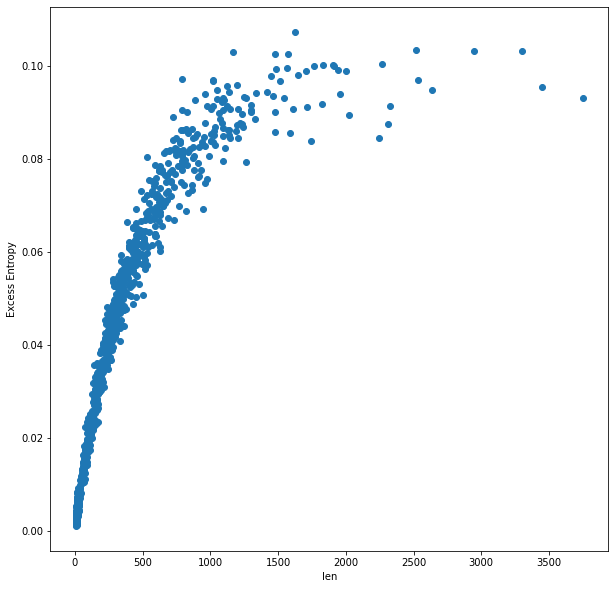

In [126]:
plt.figure(figsize=(10, 10))
plt.xlabel('len')
plt.ylabel('Excess Entropy')
plt.scatter(lens, ee)